https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [23]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('beijing_pm.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


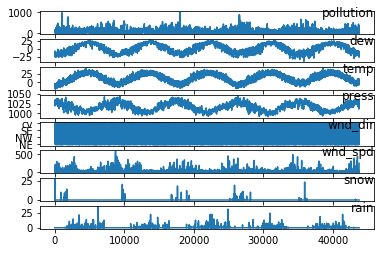

In [73]:
from pandas import read_csv
from matplotlib import pyplot

def plotData(fileName):
    dataset = read_csv(fileName, header=0, index_col=0)
    values = dataset.values
    columns = dataset.columns
    num_columns = len(columns)
    
    pyplot.figure() # TODO - update figure size automatically
    for i in range(num_columns):
        pyplot.subplot(num_columns, 1, i+1)
        pyplot.plot(values[:, i])
        pyplot.title(columns[i], y=0.5, loc='right')
    pyplot.show()
        
plotData('pollution.csv')

In [124]:
from math import sqrt
from numpy import concatenate, zeros
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def seriesToSupervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def prepareData(fileName, scaler, lookBack = 1, trainPercent=0.8, encodeColumnIndex=[]):
    dataset = read_csv(fileName, header=0, index_col=0)
    values = dataset.values
    n_features = len(dataset.columns)
    # integer encode direction
    for i in encodeColumnIndex:
        values[:,i] = LabelEncoder().fit_transform(values[:,i])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = seriesToSupervised(scaled, lookBack, 1)
    
    # split into train and test sets
    values = reframed.values
    trainSize = int(trainPercent * len(values))
    train = values[:trainSize, :]
    test = values[trainSize:, :]
    # split into input and outputs
    
    n_obs = lookBack * n_features
    trainX, trainY = train[:, :n_obs], train[:, -n_features]
    testX, testY = test[:, :n_obs], test[:, -n_features]
    # reshape input to be 3D [samples, timesteps, features]
    trainX = trainX.reshape((trainX.shape[0], lookBack, n_features))
    testX = testX.reshape((testX.shape[0], lookBack, n_features))
    
    return trainX, trainY, testX, testY

trainX, trainY, testX, testY = prepareData('pollution.csv', scaler, lookBack=7, encodeColumnIndex=[4])
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(39413, 7, 8) (39413,) (4380, 7, 8) (4380,)


Train on 39413 samples, validate on 4380 samples
Epoch 1/50
 - 3s - loss: 0.0304 - val_loss: 0.0291
Epoch 2/50
 - 2s - loss: 0.0217 - val_loss: 0.0248
Epoch 3/50
 - 2s - loss: 0.0185 - val_loss: 0.0197
Epoch 4/50
 - 2s - loss: 0.0168 - val_loss: 0.0169
Epoch 5/50
 - 2s - loss: 0.0159 - val_loss: 0.0154
Epoch 6/50
 - 2s - loss: 0.0151 - val_loss: 0.0151
Epoch 7/50
 - 2s - loss: 0.0146 - val_loss: 0.0136
Epoch 8/50
 - 2s - loss: 0.0141 - val_loss: 0.0127
Epoch 9/50
 - 2s - loss: 0.0140 - val_loss: 0.0130
Epoch 10/50
 - 2s - loss: 0.0138 - val_loss: 0.0127
Epoch 11/50
 - 2s - loss: 0.0138 - val_loss: 0.0127
Epoch 12/50
 - 2s - loss: 0.0138 - val_loss: 0.0124
Epoch 13/50
 - 2s - loss: 0.0137 - val_loss: 0.0129
Epoch 14/50
 - 2s - loss: 0.0137 - val_loss: 0.0129
Epoch 15/50
 - 2s - loss: 0.0137 - val_loss: 0.0125
Epoch 16/50
 - 2s - loss: 0.0136 - val_loss: 0.0124
Epoch 17/50
 - 2s - loss: 0.0136 - val_loss: 0.0126
Epoch 18/50
 - 2s - loss: 0.0136 - val_loss: 0.0127
Epoch 19/50
 - 2s - loss

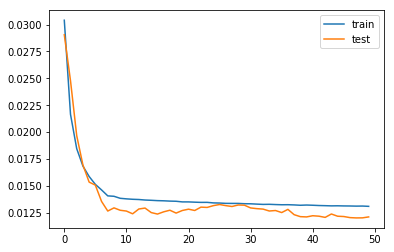

In [128]:
def trainLSTM(trainX, trainY, testX, testY, neurons=50, epochs=50, batchSize=128, verbose=2, loss='mae', optimizer='adam', plot=True):
    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    # fit network
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, validation_data=(testX, testY), verbose=verbose, shuffle=False)
    
    # plot history
    if (plot):
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()
    
    return model, history
    

model, history = trainLSTM(trainX, trainY, testX, testY, 50)

Test RMSE: 0.022


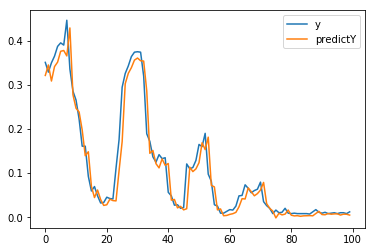

In [153]:
def reverseScale(y, scaler):
    n_scaled=len(scaler.data_max_)
    inv = concatenate((y, zeros([y.shape[0], n_scaled-1])), axis=1) # don't case the 
    inv = scaler.inverse_transform(inv)
    return inv[:, 0]

def makePrediction(model, testX, testY, rmse=True, plot=True):
    # make a prediction
    yhat = model.predict(testX)
    shapedY = testY.reshape(len(testY), 1)
    
    if (rmse):
        rmse = sqrt(mean_squared_error(yhat, shapedY))
        print('Test RMSE: %.3f' % rmse)

    predictedY = reverseScale(yhat, scaler)
    y = reverseScale(shapedY, scaler)
    
    if (plot):
        pyplot.plot(shapedY[-100:], label = 'y')
        pyplot.plot(yhat[-100:], label = 'predictY')
        pyplot.legend()
        pyplot.show()

    return predictedY, y

predictedY, y = makePrediction(model, testX, testY)

Train on 39417 samples, validate on 4380 samples
Epoch 1/50
 - 3s - loss: 0.0341 - val_loss: 0.0236
Epoch 2/50
 - 1s - loss: 0.0195 - val_loss: 0.0198
Epoch 3/50
 - 1s - loss: 0.0177 - val_loss: 0.0193
Epoch 4/50
 - 1s - loss: 0.0164 - val_loss: 0.0168
Epoch 5/50
 - 1s - loss: 0.0150 - val_loss: 0.0137
Epoch 6/50
 - 1s - loss: 0.0142 - val_loss: 0.0133
Epoch 7/50
 - 1s - loss: 0.0140 - val_loss: 0.0129
Epoch 8/50
 - 1s - loss: 0.0138 - val_loss: 0.0127
Epoch 9/50
 - 1s - loss: 0.0137 - val_loss: 0.0124
Epoch 10/50
 - 1s - loss: 0.0137 - val_loss: 0.0123
Epoch 11/50
 - 1s - loss: 0.0137 - val_loss: 0.0125
Epoch 12/50
 - 1s - loss: 0.0136 - val_loss: 0.0125
Epoch 13/50
 - 1s - loss: 0.0136 - val_loss: 0.0125
Epoch 14/50
 - 1s - loss: 0.0136 - val_loss: 0.0124
Epoch 15/50
 - 1s - loss: 0.0136 - val_loss: 0.0124
Epoch 16/50
 - 1s - loss: 0.0135 - val_loss: 0.0124
Epoch 17/50
 - 1s - loss: 0.0136 - val_loss: 0.0122
Epoch 18/50
 - 1s - loss: 0.0135 - val_loss: 0.0124
Epoch 19/50
 - 1s - loss

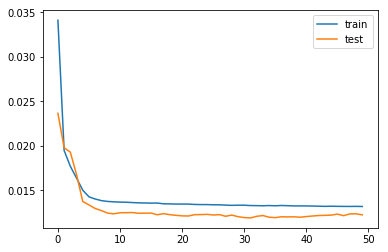

Test RMSE: 0.022


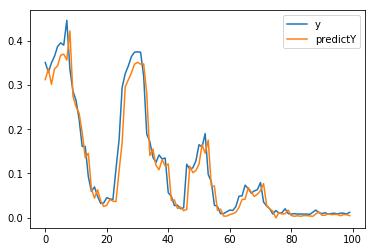

(array([ 455.4600392 ,  507.36864229,  561.77496139, ...,  118.07746478,
         117.18127131,  100.62059358]),
 array([ 481.79688934,  540.83929404,  555.59990888, ...,  142.30301452,
         127.54241334,  157.06362252]),
 <keras.callbacks.History at 0x139f1f6d8>)

In [148]:
def runLSTM(fileName, lookBack=3, encodeColumnIndex=[]):
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainX, trainY, testX, testY = prepareData(fileName, scaler, lookBack, encodeColumnIndex = encodeColumnIndex)
    model, history = trainLSTM(trainX, trainY, testX, testY)
    predictedY, y = makePrediction(model, testX, testY)
    return predictedY, y, model, history

runLSTM('pollution.csv', encodeColumnIndex=[4])

In [138]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('data/bitcoin_price.csv',  parse_dates = ['Date'], index_col='Date', usecols=['Date', 'Open', 'High', 'Low', 'Close'])
dataset = dataset.iloc[::-1]
dataset.index.name = 'Date'
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('bitcoin.csv')

              Open    High     Low   Close
Date                                      
2013-04-28  135.30  135.98  132.10  134.21
2013-04-29  134.44  147.49  134.00  144.54
2013-04-30  144.00  146.93  134.05  139.00
2013-05-01  139.00  139.89  107.72  116.99
2013-05-02  116.38  125.60   92.28  105.21


Train on 1476 samples, validate on 164 samples
Epoch 1/50
 - 2s - loss: 0.0246 - val_loss: 0.2243
Epoch 2/50
 - 0s - loss: 0.0172 - val_loss: 0.1062
Epoch 3/50
 - 0s - loss: 0.0055 - val_loss: 0.0787
Epoch 4/50
 - 0s - loss: 0.0044 - val_loss: 0.0362
Epoch 5/50
 - 0s - loss: 0.0032 - val_loss: 0.0412
Epoch 6/50
 - 0s - loss: 0.0038 - val_loss: 0.0458
Epoch 7/50
 - 0s - loss: 0.0031 - val_loss: 0.0500
Epoch 8/50
 - 0s - loss: 0.0040 - val_loss: 0.0510
Epoch 9/50
 - 0s - loss: 0.0032 - val_loss: 0.0515
Epoch 10/50
 - 0s - loss: 0.0070 - val_loss: 0.0648
Epoch 11/50
 - 0s - loss: 0.0048 - val_loss: 0.0709
Epoch 12/50
 - 0s - loss: 0.0050 - val_loss: 0.0302
Epoch 13/50
 - 0s - loss: 0.0035 - val_loss: 0.0499
Epoch 14/50
 - 0s - loss: 0.0067 - val_loss: 0.0443
Epoch 15/50
 - 0s - loss: 0.0042 - val_loss: 0.0752
Epoch 16/50
 - 0s - loss: 0.0047 - val_loss: 0.0376
Epoch 17/50
 - 0s - loss: 0.0030 - val_loss: 0.0410
Epoch 18/50
 - 0s - loss: 0.0038 - val_loss: 0.0583
Epoch 19/50
 - 0s - loss: 

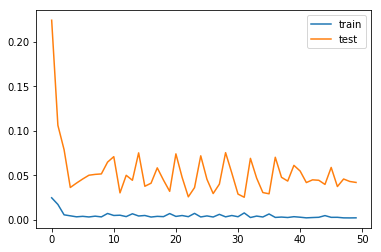

Test RMSE: 0.054


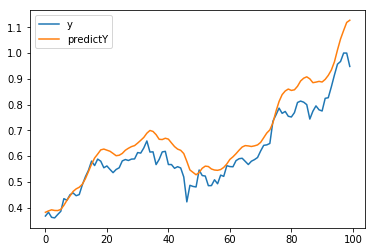

In [154]:
predictedY, y, _, _ = runLSTM('bitcoin.csv', lookBack=15)

In [155]:
print(predictedY[-10:])
print(y[-10:])

[ 6579.61241351  6654.23010468  6768.33420052  6919.93560138  7152.91824439
  7493.24186952  7806.06878276  8047.46913457  8276.24576537  8338.49159778]
[ 5754.43995488  6114.85003212  6132.0199543   6440.97011275  6777.76985261
  7087.52981818  7164.47985878  7404.51989206  7403.21991552  7023.10030504]
